In [1]:
import os,sys,string, time
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Variables_bins as Variables_bins
import Utilities.Functions as Functions
import Utilities.Sys_unc_variables as Sys_unc
from Utilities.ipython_exit import exit

print ('Success')

Success


# Reading in .pkl files

In [2]:
Params = {"Run":"run1", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":"overlay",
          "Load_standard_bkgs":True,
          "Load_DetVars":False, #overlay DetVar samples
          "Only_keep_common_DetVar_evs":True, #Removes events not in all DetVar samples
          "Load_Signal_DetVars":False, #ee DetVar samples
          "Load_data":False,
          "FLATTEN":True, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "Load_truth_vars":False, 
          "Load_lepton_signal":True,
          "Load_lepton_dirac":False,
          'Load_pi0_signal_DetVars':False, #pi0 DetVar samples
          "Load_pi0_signal":False,
          "Load_pi0_dirac":False}

# Params, samples = Functions.create_sample_list(Params)
Params, samples = Functions.new_create_sample_list(Params)
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"

Loading these run1 samples: 
['overlay', 'dirtoverlay', 'beamoff', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee']


In [3]:
samples_dict = Functions.Load_initial_pkls(samples, Params, loc_pkls, "_Finished")

for sample in samples_dict:
    print(f"{sample} length is " + str(len(samples_dict[sample])))
print("Loading these variables:")
# print(samples_dict[sample].keys())

overlay length is 987945
dirtoverlay length is 230185
beamoff length is 184430
2_ee length is 51135
10_ee length is 43415
20_ee length is 47592
50_ee length is 45943
100_ee length is 48963
150_ee length is 47991
Loading these variables:
Index(['run', 'sub', 'evt', 'nslice', 'n_pfps', 'n_tracks', 'n_showers',
       'swtrig_pre', 'swtrig_post', 'trk_sce_start_x_v', 'trk_sce_start_y_v',
       'trk_sce_start_z_v', 'trk_sce_end_x_v', 'trk_sce_end_y_v',
       'trk_sce_end_z_v', 'shr_theta_v', 'shr_phi_v', 'shr_px_v', 'shr_py_v',
       'shr_pz_v', 'shrclusdir0', 'shrclusdir1', 'shrclusdir2',
       'shr_energy_tot', 'trk_theta_v', 'trk_phi_v', 'trk_dir_x_v',
       'trk_dir_y_v', 'trk_dir_z_v', 'trk_energy', 'trk_energy_hits_tot',
       'trk_energy_tot', 'trk_score_v', 'trk_calo_energy_u_v', 'trk_end_x_v',
       'trk_chipr_best', 'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y',
       'NeutrinoEnergy2', 'SliceCaloEnergy2', 'nu_flashmatch_score',
       'contained_sps_ratio', 'flash

## Applying Software Trigger

In [4]:
def Apply_swtrig(df):
    query="swtrig_pre>0"
    df.query(query)

def Apply_flash_shift(df, sample_type):
    #Only required for beam off, overlay, dirtoverlay and signal (i.e all except beamon data)
    if(sample_type=="beamoff"): df["flash_time"]=df["flash_time"] -0.359
    else: df["flash_time"]=df["flash_time"] - 0.304
    
Pre_swtrig_dict = {}
swtrig = {}

apply_swtrig = True
if(apply_swtrig): print("Applying software trigger!")
for sample in samples_dict:
    Pre_swtrig_dict[sample] = len(samples_dict[sample]) #Should weight this properly, i.e take sum of weights for the total number.
    if(apply_swtrig):
        # Apply_swtrig(samples_dict[sample])
        if Params["Run"]=="run1":
            swtrig[sample] = samples_dict[sample].query("swtrig_pre>0").copy()
        if Params["Run"]=="run3":
            swtrig[sample] = samples_dict[sample].query("swtrig_post>0").copy() #Took this from Owen's code, should check exactly what it's doing
    else: swtrig[sample] = samples_dict[sample].copy()
    if sample != "beamgood":
        Apply_flash_shift(swtrig[sample], sample)
        
for sample in samples_dict:
    swtrig_effic = 100*(len(swtrig[sample])/Pre_swtrig_dict[sample])
    print(f"{sample} efficiency is " + str(swtrig_effic) + "%")
    
print(swtrig.keys())

Applying software trigger!
overlay efficiency is 99.96710343187121%
dirtoverlay efficiency is 99.75715185611574%
beamoff efficiency is 100.0%
2_ee efficiency is 100.0%
10_ee efficiency is 100.0%
20_ee efficiency is 100.0%
50_ee efficiency is 100.0%
100_ee efficiency is 100.0%
150_ee efficiency is 100.0%
dict_keys(['overlay', 'dirtoverlay', 'beamoff', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee'])


# Plotting variables before preselection

In [ ]:
#Want to have arrows drawn on for where the preselection cut goes
HNL_mass = "100_ee"
if Params["Load_pi0_signal"]:
    HNL_mass = f"{HNL_mass}_pi0" #only plotting one at a time
variable = 'flash_time'

samples_plotting = {"overlay":swtrig["overlay"],
                    "dirtoverlay":swtrig["dirtoverlay"],
                    "beamoff":swtrig["beamoff"],
                    "signal":swtrig[HNL_mass]}

if Params["Run"] == "run1":
    sample_norms = {"overlay":Constants.run1_POT_scaling_dict["overlay"], #WAS using SF_overlay_run1
                    "dirtoverlay":Constants.run1_POT_scaling_dict["dirtoverlay"],
                    "beamoff":Constants.run1_POT_scaling_dict["beamoff"],
                    "signal":Constants.run1_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
elif Params["Run"] == "run3":
    sample_norms = {"overlay":Constants.run3_POT_scaling_dict["overlay"],
                    "dirtoverlay":Constants.run3_POT_scaling_dict["dirtoverlay"],
                    "beamoff":Constants.run3_POT_scaling_dict["beamoff"],
                    "signal":Constants.run3_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc

if Params["Load_data"] == True:
    data_dict = {"beamgood":samples_dict["beamgood"]}
    data_norm = {"beamgood":1.0} #No scaling as this is data, should have scaled MC to this POT.
    samples_plotting.update(data_dict)
    sample_norms.update(data_norm)
    
PT.HNL_scaling_calculator(samples_plotting,sample_norms)


In [ ]:
for sample in samples_plotting:
    print(sample)
    
print(Constants.Preselection_dict_for_plot)

## Plot data and MC

In [ ]:
samples_plotting["overlay"].keys()

In [ ]:
#Calculate sys
Calculate_sys = True
variable = 'flash_time'

reload(PT)
reload(Functions)
reload(Constants)
reload(Sys_unc)
reload(Variables_bins)

if Params["Run"] == "run1": 
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
    PLOTSCALE = 240000000
if Params["Run"] == "run3": 
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc
    PLOTSCALE = 240000000
    
if isinstance(Constants.variable_names_dict[variable],str):x_string = Constants.variable_names_dict[variable]
else: x_string=variable
if variable=='trk_score_v':ylabel = 'Reconstructed objects'
else: ylabel='Events'
if variable=='nslice':xticks=[0,1]
else: xticks=[]

if (variable.startswith('min')) or (variable.startswith('max')):
    dropdupes=True
    print("Only keeping one entry per event for this plot!")
else: dropdupes=False

BINS = Variables_bins.Presel_bins[variable]
XLIMS = [BINS[0],BINS[-1]]

Log_var = Variables_bins.Log_vars[variable]
cut_line = 0.0
# arrow_place = Variables_bins.arrow_places[variable]
arrow_place = []
print("Arrow place is " + str(arrow_place))

Name = ""
if Params["Load_pi0_signal"] == True: Name = "pi0/"
if Calculate_sys==True: Sys_name = "with_sys"
if Calculate_sys==False: Sys_name = "no_sys"
if arrow_place != []: end_name = "_arrow"
else: end_name = ""

In [ ]:
savefig=False

print(f"Plotting {variable} for " + Params["Run"])

bins_test = [0,25.0]
bins_test = BINS
print("nbins " + str(len(bins_test)-1))

PT.Plot_preselection_variable_data(variable, samples_plotting, sample_norms, xlabel=x_string, xlims=XLIMS, bins=bins_test, HNL_mass=100,
                                   HNLplotscale=PLOTSCALE,cutline=cut_line,legloc="upper right", show_ev_nums=False, CalcSys=Calculate_sys,logy=Log_var, 
                                   xticks = xticks, sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel=ylabel, 
                                   arrow_place=arrow_place, legsize=16, dropdupes=dropdupes, err_print=False, chi_squared=True, 
                                   dirt_frac_error=0.9)

if savefig == True:
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}{end_name}.png")
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}{end_name}.pdf")

## Plotting only highest E object

In [ ]:
Highest_E_placeholder = Functions.only_keep_highest_E(samples_dict[HNL_mass])

samples_plotting = {"overlay":samples_dict["overlay"],
           "dirtoverlay":samples_dict["dirtoverlay"],
           "beamoff":samples_dict["beamoff"],
           "signal":Highest_E_placeholder}

PT.Plot_preselection_variable(variable, samples_plotting, sample_norms, xlabel=[],xlims=[1,100],bins=100, HNL_mass=HNL_mass,
                              HNLplotscale=600000,cutline=0.0,legloc="upper right")

plt.savefig("plots/Preselection_variables/" + Params["Run"] + "_" + str(HNL_mass) + "_MeV_" + str(variable)+"_highest_E.png")

## Plot only signal samples before preselection

In [ ]:
#Need a new plotting function for this
reload(Constants)

# Pre-selection cuts

In [6]:
if Params["FLATTEN"] == True: Preselection_dict = Constants.Preselection_dict 
else: Preselection_dict = Constants.Preselection_dict_for_plot
        
if Params["Run"] == "run3": Preselection_dict.update(Constants.Preselection_dict_crtveto) #Adding crtveto cut
        
if (Params["Load_DetVars"] == True) and (Params["Run"] == "run3"):
    removed=Preselection_dict.pop('Fiducial_cut')        

print("Preselection is:" + "\n")
print(Preselection_dict)


Preselection is:

{'nslice': 'nslice==1', 'flash_time': 'flash_time > 6.55 and flash_time < 16.5', 'nu_flashmatch_score': 'nu_flashmatch_score < 15', 'NeutrinoEnergy2': 'NeutrinoEnergy2 < 500', 'Fiducial_cut': 'min_y>-112 and max_y<112 and min_z>14 and max_z<1020 and min_x>9 and max_x<253', 'contained_fraction': 'contained_fraction > 0.9', 'n_pfps': 'n_pfps < 6'}



In [7]:
sample_dict_copy = {}
for sample in samples_dict:
    sample_dict_copy[sample] = swtrig[sample].copy()

    
if (Params["Load_DetVars"] == True) or (Params["Load_Signal_DetVars"] == True) or (Params['Load_pi0_signal_DetVars'] == True):
    Preselected = Functions.Preselection_DetVars(sample_dict_copy, Preselection_dict)
else:
    if Params["FLATTEN"] == False:
        Efficiency_dict, Preselected = Functions.Preselection_weighted_efficiency(sample_dict_copy, Preselection_dict)
    if Params["FLATTEN"] == True:
        Efficiency_dict, Preselected = Functions.Flattened_Preselection_weighted_efficiency(sample_dict_copy, Preselection_dict, Params["Run"])
    
    print(Efficiency_dict.keys())
print("Finished pre-selection cuts.")
        
print(sample_dict_copy.keys())


dict_keys(['overlay', 'dirtoverlay', 'beamoff', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee'])
dict_keys(['overlay', 'dirtoverlay', 'beamoff', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee'])


In [14]:
Preselection_signal_min, Preselection_signal_max = Functions.Get_signal_efficiency_range(Params, Preselection_dict, Efficiency_dict)

print(Preselection_signal_max)
print(Preselection_signal_min)

[1.0, 0.6146315760281761, 0.5823234144041709, 0.5368701295099698, 0.5334867855459109, 0.4468787265315178, 0.39951191103469313, 0.39482514767464433]
[1.0, 0.5488203164592601, 0.519483079002196, 0.47727912607691875, 0.47451996170955574, 0.391632411734895, 0.34664113970381216, 0.34382566585956414]


## Printing and plotting efficiencies

In [19]:
Functions.Print_efficiency_numbers(Params, Preselected, Efficiency_dict)


run1
overlay efficiency is 5.330473322659762%
dirtoverlay efficiency is 1.2789708124725403%
beamoff efficiency is 0.7733628790241076%
2_ee efficiency is 39.48251476746443%
10_ee efficiency is 34.517013016670475%
20_ee efficiency is 36.251527909819366%
50_ee efficiency is 34.38256658595641%
100_ee efficiency is 34.63843171280605%
150_ee efficiency is 35.29244908379191%
overlay 3958.9489134977443
dirtoverlay 614.0299216251633
beamoff 3925.0940530199045
2_ee 0.0010132128674412888
10_ee 0.00534610962003519
20_ee 3.593141817008203e-09
50_ee 1.071795323284737e-06
100_ee 0.00010705890012200402
150_ee 0.001983755222614785
Sum of bkgs: 8498.072888142811
Sum of bkgs effic: 1.3492952143999961%


Do you want to save the figure? y/n  n


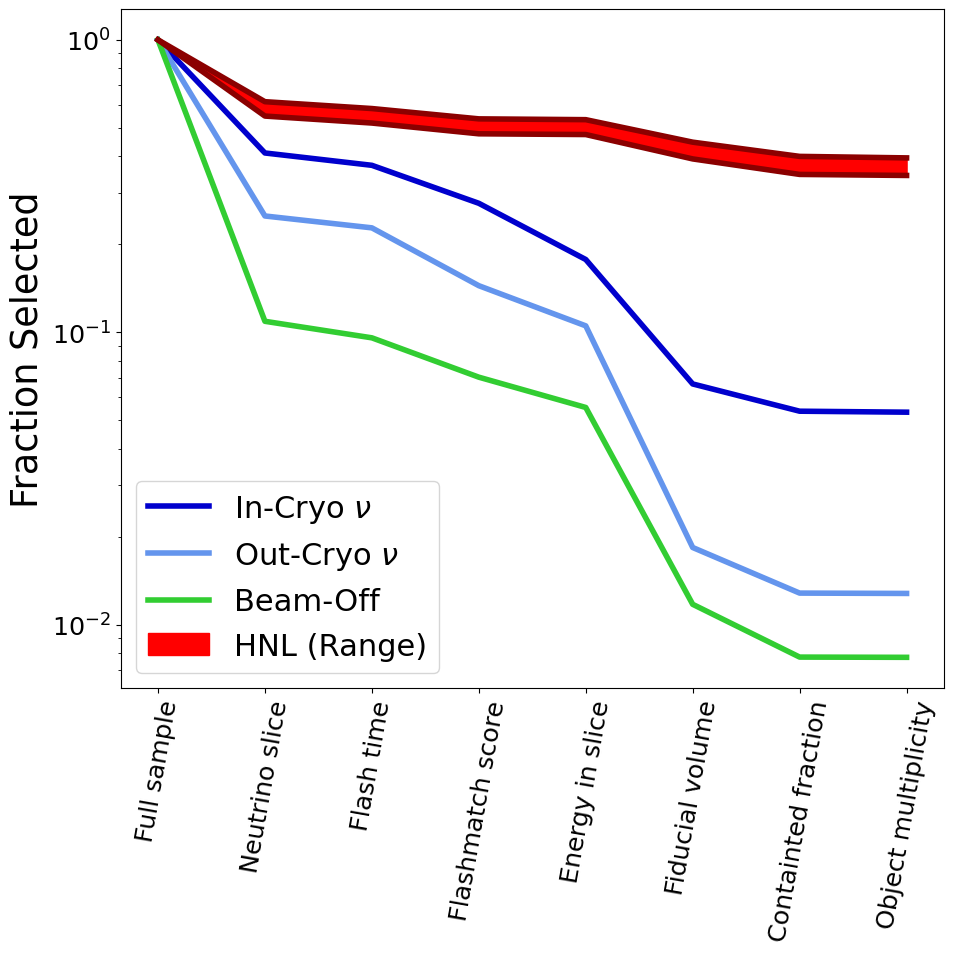

In [24]:
PT.Plot_preselection_efficiency(Params, Preselection_dict, Efficiency_dict, Preselection_signal_min, Preselection_signal_max, log=True)


## Only select highest energy object and "Prepare" for xgboost

In [36]:
trk_score_cut = True

Prepared_dict = {}
if(trk_score_cut): Preselected_dict = Functions.Remove_high_trk_score_objects(Preselected, threshold=0.97)
else: Preselected_dict = Preselected.copy()

Highest_E_placeholder = Functions.only_keep_highest_E(Preselected_dict)
Prepared_dict = Functions.Prepare_dfs_for_xgb(Highest_E_placeholder)

print(Prepared_dict.keys())

Removing tracks with trk_score_v > 0.97
dict_keys(['overlay', 'dirtoverlay', 'beamoff', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee'])


# Save pkls

In [47]:
print_vals = input("Do you want to save the pickle files? y/n ")
if print_vals == "y":
    Functions.Save_preselected_pkls(Prepared_dict, Params, loc_pkls, "trk_Finished")
else:
    print("Not saving pickle files, move onto next cell")

Do you want to save the pickle files? y/n  y


Saving run1 Preselected overlay .pkl
Saving run1 Preselected dirtoverlay .pkl
Saving run1 Preselected beamoff .pkl
Saving run1 Preselected 2_ee .pkl
Saving run1 Preselected 10_ee .pkl
Saving run1 Preselected 20_ee .pkl
Saving run1 Preselected 50_ee .pkl
Saving run1 Preselected 100_ee .pkl
Saving run1 Preselected 150_ee .pkl


## Plotting single mass point and background

In [57]:
print(Efficiency_dict[sample])

[1.0, 0.41039600542147925, 0.3724093369051585, 0.27613843869935195, 0.17737803403451266, 0.06657712856743864, 0.053715014463364005, 0.053304733226597616]


In [61]:
#Making plot of efficiency wrt previous selection
effic_wrt_prev = {}
for sample in Efficiency_dict:
    effic_list = []
    for i, effic in enumerate(Efficiency_dict[sample]):
        if i==0: continue
        effic_list.append( Efficiency_dict[sample][i]/Efficiency_dict[sample][i-1])
    effic_wrt_prev[sample] = effic_list

print(Efficiency_dict['overlay'])
print(effic_wrt_prev)

var_names = []
for var in Preselection_dict.keys():
    var_names.append(Constants.presel_var_names[var])

print(var_names)
    

[1.0, 0.41039600542147925, 0.3724093369051585, 0.27613843869935195, 0.17737803403451266, 0.06657712856743864, 0.053715014463364005, 0.053304733226597616]
[0.41039600542147925, 0.9074389905980975, 0.7414917171361796, 0.6423518394251315, 0.37534032288622976, 0.8068088188716929, 0.9923618891130297]
['Neutrino slice', 'Flash time', 'Flashmatch score', 'Energy in slice', 'Fiducial volume', 'Containted fraction', 'Object multiplicity']


In [78]:
print(x)
print(bin_cents)
print(effic_wrt_prev[sample])

[0 1 2 3 4 5 6]
[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
[0.5728711635559085, 0.9549415725886315, 0.9127346261536866, 0.9942623416463102, 0.8105930750771341, 0.8810178332276029, 0.9954396351708136]


[0 1 2 3 4 5 6 7]
[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]


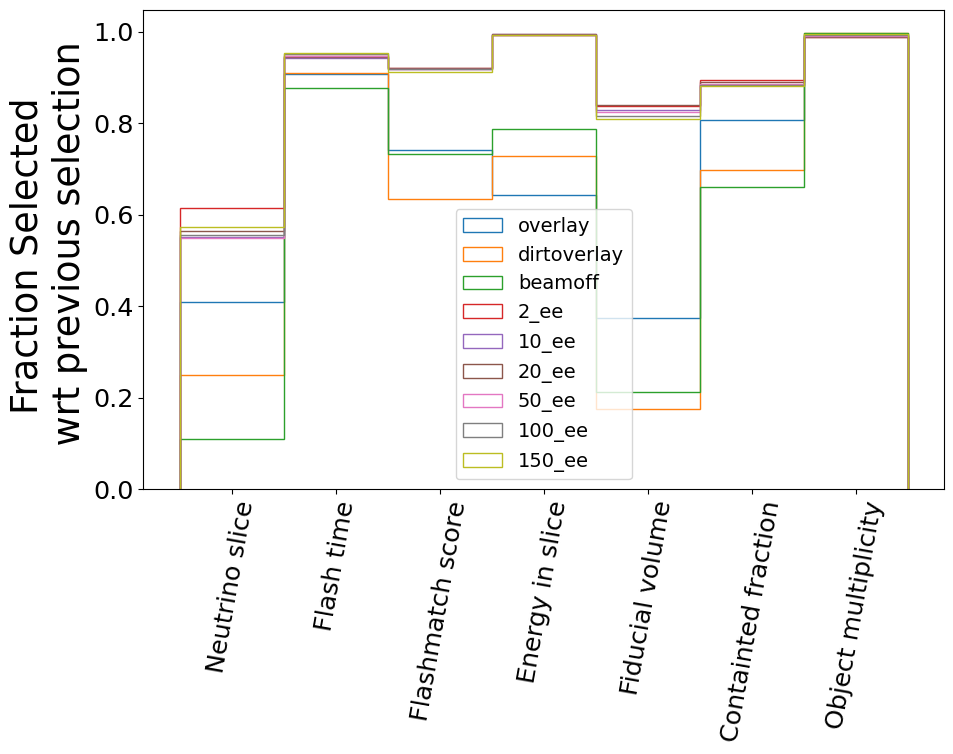

In [90]:
plt.figure(figsize=[10,8])
x = np.arange(0, len(effic_wrt_prev[sample])+1)
print(x)
xticks = var_names
bin_cents, centre_bars = [], []
for i, val in enumerate(x):
    bin_cents.append((2*val+1)/2) 
    centre_bars.append((2*val+1)/2+0.5)
bin_cents.pop()
print(bin_cents)
for sample in effic_wrt_prev:
    plt.hist(bin_cents, bins=x, weights=effic_wrt_prev[sample], label=sample, histtype="step")
    # plt.xticks(x, var_names)
    
plt.xticks(bin_cents,var_names,rotation=80)
plt.ylabel("Fraction Selected \n wrt previous selection")
# plt.yscale("log")
plt.legend(loc='best',prop={'size': 14})

plt.tight_layout()

In [ ]:
#Plotting efficiency
signal_mass = 220
plt.figure(figsize=[10,10])
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[signal_mass],label=f"{signal_mass} MeV HNL",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict['overlay'],label="MC run1 overlay",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict['dirtoverlay'],label="MC run1 dirt",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict['beamoff'],label="MC run1 EXT",lw=4,markersize=15)
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict[effic])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
#plt.yscale("log")
plt.legend()


## Plotting just signal

In [ ]:
plt.figure(figsize=[10,10])

for HNL_mass in Constants.HNL_mass_samples:
    plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[HNL_mass],label=f"{HNL_mass} MeV HNL",lw=4,markersize=15)
    
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict[effic])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
# plt.yscale("log")
plt.legend()

plt.savefig("plots/Preselection_efficiencies/Signal_only_"+Params["Run"]+"_"+Params["Flat_state"]+".png")

# Testing code

## Making sum of weights (only for unflattened)

In [ ]:
def Sum_weights(df):
    weight = df["weight"] #Just one value per event
    sum_weights = sum(weight)
    return sum_weights

for sample in ['overlay', 'dirtoverlay']:
    sum_weights_placeholder = Sum_weights(samples_dict[sample])
    print(f"{sample} sum weights is " + str(sum_weights_placeholder))

In [ ]:
#Testing what the variables look like
variable = "dvtx_x_boundary"
def test_variables(df):
    test_signal = df[variable]
    print(type(test_signal))
    print(len(test_signal))
test_variables(df_overlay_run1)
test_variables(df_dirt_run1)
test_variables(df_EXT_run1)
test_variables(df_signal_run1)

In [ ]:
#print(overlay_from_pkl['nslice'])
#print("Flat Overlay .pkl is "+str(len(FLAT_overlay_from_pkl))+" entries long.")

print("-----Unflattened-----")
unique_var = overlay_from_pkl["nslice"].unique()
print(unique_var)
unique_var = overlay_from_pkl["n_pfps"].unique()
print(unique_var)
print(overlay_from_pkl["n_pfps"])
print(type(overlay_from_pkl["n_pfps"][0]))

# for var in overlay_from_pkl.keys():
#     if type(overlay_from_pkl[var][1]) == "numpy.ndarray":
#         print(var)

# print("-----Flattened-----")
# unique_var = FLAT_overlay_from_pkl["nslice"].unique()
# print(unique_var)
# unique_var = FLAT_overlay_from_pkl["n_pfps"].unique()
# print(unique_var)
# print(FLAT_overlay_from_pkl["n_pfps"])
# print(type(FLAT_overlay_from_pkl["n_pfps"]))

## Depracated code